# Gridsearch for best ResNet model 

## Set up packages and server

In [22]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [23]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import timm
from sklearn.model_selection import GroupShuffleSplit

# Others
import os
import sys
import gc
from pathlib import Path
import os.path


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.lines as mlines


from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm.notebook import tqdm


# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)
import dataset
import visualizations

In [24]:
torch.cuda.empty_cache()

In [25]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


## Load and preprocess the training and validation data

In [5]:
def extract_building_id(filepath):
    """
    Extracts the building ID from the given filepath string.
    Knowing that the building ID always contains an underscore and considering the filename
    format '[age_right]_[building_id]_[subscript].jpg', this function returns the 'building_id'.
    """
    # Isolate the filename from the filepath
    filename = filepath.split('/')[-1]
    # Split the filename at underscores
    parts = filename.split('_')
    # Considering the first part is age_right and the last part is the subscript with .jpg,
    # the building ID is everything in between.
    # Rejoin the middle parts to account for underscores within the building ID itself.
    building_id = '_'.join(parts[1:-1])
    return building_id

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined
    
def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket


age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

In [6]:
directories = [
    #Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    #Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    #Path('/workspace/workspace/ufo-prediction/image_data_FRA'),
    Path('/workspace/workspace/ufo-prediction/image_data_NLD_adv'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP_adv'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA_adv')
   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
building_ids = pd.Series(filepaths.apply(extract_building_id), name='Building ID')

# Filter to exclude 'Unknown' age brackets and corresponding filepaths and building IDs
filtered_indices = age_brackets != 'Unknown'
filtered_age_brackets = age_brackets[filtered_indices]
filtered_filepaths = filepaths[filtered_indices]
filtered_building_ids = building_ids[filtered_indices]

# Create DataFrame
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets, filtered_building_ids], axis=1)
trainval_df = trainval_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

print(trainval_df.head())

                                            Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1985-1999   
1  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
2  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
3  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
4  /workspace/workspace/ufo-prediction/image_data...    1900-1924   

                  Building ID  Target  
0  v0.1-ESP.14.2.1.42_1-19840       5  
1    v0.1-FRA.11.2.3.5_1-2637       0  
2   v0.1-FRA.13.2.1.2_1-13623       0  
3       v0.1-NLD.7.44_1-49297       4  
4    v0.1-FRA.7.2.6.8_1-19227       0  


In [7]:
len(trainval_df)

40535

In [8]:
# Initialize the GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=np.random.randint(1, 10000))

# Split the DataFrame into training and validation+test sets
# We use 'Building ID' as the groups to keep images of the same building together
train_idx, valtest_idx = next(gss.split(trainval_df, groups=trainval_df['Building ID']))
train_df = trainval_df.iloc[train_idx]
valtest_df = trainval_df.iloc[valtest_idx]

# Now split the validation+test set into validation and test sets
gss_val_test = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=1)
val_idx, test_idx = next(gss_val_test.split(valtest_df, groups=valtest_df['Building ID']))
val_df = valtest_df.iloc[val_idx]
test_df = valtest_df.iloc[test_idx]

# Check the sizes of each set and sample outputs
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Testing set size:", test_df.shape)
print("\nSample training data:", train_df.head())
print("\nSample validation data:", val_df.head())
print("\nSample testing data:", test_df.head())


Training set size: (24094, 4)
Validation set size: (11519, 4)
Testing set size: (4922, 4)

Sample training data:                                             Filepath Age Brackets  \
1  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
3  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
4  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
6  /workspace/workspace/ufo-prediction/image_data...    1960-1969   
7  /workspace/workspace/ufo-prediction/image_data...    1900-1924   

                Building ID  Target  
1  v0.1-FRA.11.2.3.5_1-2637       0  
3     v0.1-NLD.7.44_1-49297       4  
4  v0.1-FRA.7.2.6.8_1-19227       0  
6  v0.1-FRA.6.3.7.4_1-18036       3  
7     v0.1-NLD.12.9_1-14759       0  

Sample validation data:                                              Filepath Age Brackets  \
0   /workspace/workspace/ufo-prediction/image_data...    1985-1999   
2   /workspace/workspace/ufo-prediction/image_data...    1900-1924   
8   /work

In [9]:
def check_building_id_exclusivity(train_df, val_df, test_df):
    # Extract building IDs from each dataset into sets
    train_ids = set(train_df['Building ID'])
    val_ids = set(val_df['Building ID'])
    test_ids = set(test_df['Building ID'])

    # Check for intersections between the sets
    train_val_intersection = train_ids.intersection(val_ids)
    train_test_intersection = train_ids.intersection(test_ids)
    val_test_intersection = val_ids.intersection(test_ids)

    # Report the results
    if not train_val_intersection and not train_test_intersection and not val_test_intersection:
        print("Check passed: No building ID appears in more than one dataset.")
    else:
        if train_val_intersection:
            print("Overlap found between training and validation datasets:", train_val_intersection)
        if train_test_intersection:
            print("Overlap found between training and testing datasets:", train_test_intersection)
        if val_test_intersection:
            print("Overlap found between validation and testing datasets:", val_test_intersection)

# Example usage:
check_building_id_exclusivity(train_df, val_df, test_df)


Check passed: No building ID appears in more than one dataset.


In [10]:
class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, -1])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label



In [11]:
augument_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = AgeBracketDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Model setup

In [12]:
def train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7, config_details=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False
    history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        # Use tqdm for the training loop
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_description(f'Training Loss: {running_loss / (progress_bar.n + 1):.4f}')
            progress_bar.update()  # Ensure this call is here to update the progress for each iteration
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history.append({'epoch': epoch + 1, 'validation_loss': avg_val_loss, **config_details})

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step based on validation loss

        # Check for improvement based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    progress_bar.close()
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights based on lowest validation loss
    model.load_state_dict(best_model_wts)
    history_df = pd.DataFrame(history)
    return best_val_loss, history_df  # Return the best validation loss achieved


## Grid search 3 over learning rate, data augumentation and weights

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a DataFrame to collect all data
all_data = pd.DataFrame()
# Example hyperparameters for the grid search
batch_sizes = [32]  # Standard across tests to focus on other variables
learning_rates = [0.0005, 0.00025]  # Add more as needed
unfreeze_options = ['last_two']  # Consistent as 'last_three' was too unstable
weight_decays = [0.0005, 0.001, 0.0025, 0.005]
augument_data = [False, True] 

# Placeholder for best model's performance, now focusing on validation loss
best_loss = float('inf')  # Use infinity as the initial value for the best loss
best_params = {}

# Updated train_and_evaluate function that returns the best validation loss

for batch_size in batch_sizes:
    for lr in learning_rates:
        for unfreeze_option in unfreeze_options:
            for weight_decay in weight_decays:
                for augument in augument_data:

                    print(f"Training with batch size: {batch_size}, learning rate: {lr}, unfreeze option: {unfreeze_option}, weight_decay: {weight_decay}, augument: {augument}")

                    # Load a pretrained ResNet model
                    model = models.resnet18(pretrained=True)
                    
                    # Freeze all parameters first
                    for param in model.parameters():
                        param.requires_grad = False

                    # Replace the last fully connected layer to adapt to the number of classes (7 in this case)
                    num_classes = 7
                    num_ftrs = model.fc.in_features
                    model.fc = nn.Linear(num_ftrs, num_classes)    
                    
                    # Unfreeze the selected layers based on unfreeze_option
                    if unfreeze_option == 'last_two':
                        for param in model.layer4.parameters():
                            param.requires_grad = True
                        for param in model.fc.parameters():
                            param.requires_grad = True
                    elif unfreeze_option == 'last_three':
                        # Unfreeze both the last block and the fully connected layer
                        for param in model.layer3.parameters():
                            param.requires_grad = True
                        for param in model.layer4.parameters():
                            param.requires_grad = True
                        for param in model.fc.parameters():
                            param.requires_grad = True
                    
                    model = model.to(device)
                    #print(model)

                    # Assuming you've already defined your datasets
                    # Initialize datasets with the appropriate transforms based on the augment flag
                    final_transform = augument_transforms if augument else train_transforms
                    train_dataset = AgeBracketDataset(train_df, transform=final_transform)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                    val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
                    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
                    criterion = nn.CrossEntropyLoss()
                    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=2, verbose=True)
                    
                    # Prepare config details for data recording
                    config_details = {
                        'batch_size': batch_size,
                        'learning_rate': lr,
                        'unfreeze_option': unfreeze_option,
                        'weight_decay': weight_decay,
                        'augument': augument
                    }

                    
                    # Run training and evaluation, now expecting validation loss as the return value
                    val_loss, data_df = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, patience=6, config_details=config_details)  # Adjust num_epochs and patience as needed

                    # Append results to the master DataFrame
                    all_data = pd.concat([all_data, data_df], ignore_index=True)
                    # Save the complete data to CSV
                    all_data.to_csv('/workspace/workspace/ufo-prediction/demo/gridsearch3b.csv', index=False)

                    # Update best model tracking based on validation loss
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {'batch_size': batch_size, 'learning_rate': lr, 'unfreeze_option': unfreeze_option, 'weight_decay': weight_decay, 'augument': augument}


# Print the best parameters and validation loss
print(f"Best Parameters: {best_params}, Best Validation Loss: {best_loss}")


Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.0005, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/15, Training Loss: 1.8986, Validation Loss: 1.9326


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8446, Validation Loss: 1.8987


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8203, Validation Loss: 1.9550


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8027, Validation Loss: 1.9170


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.7902, Validation Loss: 1.9375
Epoch     5: reducing learning rate of group 0 to 1.2500e-04.


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.7124, Validation Loss: 1.8593


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.6756, Validation Loss: 1.8983


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.6483, Validation Loss: 1.8911


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.6265, Validation Loss: 1.8913
Epoch     9: reducing learning rate of group 0 to 3.1250e-05.


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.5708, Validation Loss: 1.9389


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.5535, Validation Loss: 1.9376


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.5347, Validation Loss: 1.9446
Epoch    12: reducing learning rate of group 0 to 7.8125e-06.
Early stopping triggered after 12 epochs.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.0005, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9297, Validation Loss: 1.9530


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8814, Validation Loss: 1.9070


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8690, Validation Loss: 1.9159


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8627, Validation Loss: 1.8935


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8556, Validation Loss: 1.9236


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8492, Validation Loss: 1.9157


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8419, Validation Loss: 1.9088
Epoch     7: reducing learning rate of group 0 to 1.2500e-04.


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8078, Validation Loss: 1.9313


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.7862, Validation Loss: 1.9073


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.7784, Validation Loss: 1.9090
Epoch    10: reducing learning rate of group 0 to 3.1250e-05.
Early stopping triggered after 10 epochs.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.001, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9003, Validation Loss: 1.9739


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8529, Validation Loss: 1.9829


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8455, Validation Loss: 1.8903


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8320, Validation Loss: 1.8991


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8238, Validation Loss: 1.9150


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8137, Validation Loss: 1.9253
Epoch     6: reducing learning rate of group 0 to 1.2500e-04.


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.7490, Validation Loss: 1.9067


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7191, Validation Loss: 1.8718


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.6985, Validation Loss: 1.8909


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.6812, Validation Loss: 1.8798


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.6659, Validation Loss: 1.8904
Epoch    11: reducing learning rate of group 0 to 3.1250e-05.


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.6308, Validation Loss: 1.8911


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.6106, Validation Loss: 1.8910


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.6045, Validation Loss: 1.8947
Epoch    14: reducing learning rate of group 0 to 7.8125e-06.
Early stopping triggered after 14 epochs.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.001, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9232, Validation Loss: 1.9976


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8931, Validation Loss: 2.0357


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8860, Validation Loss: 1.9923


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8848, Validation Loss: 1.8999


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8766, Validation Loss: 1.9769


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8704, Validation Loss: 1.9047


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8656, Validation Loss: 1.8998
Epoch     7: reducing learning rate of group 0 to 1.2500e-04.


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8349, Validation Loss: 1.9096


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8229, Validation Loss: 1.9156


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8095, Validation Loss: 1.9144
Epoch    10: reducing learning rate of group 0 to 3.1250e-05.


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.7958, Validation Loss: 1.8972


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.7879, Validation Loss: 1.8995


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.7842, Validation Loss: 1.8870


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.7767, Validation Loss: 1.8996


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.7707, Validation Loss: 1.8762
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.0025, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9111, Validation Loss: 1.9239


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8814, Validation Loss: 1.9091


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8779, Validation Loss: 1.9235


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8731, Validation Loss: 1.9462


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8590, Validation Loss: 1.9061


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8448, Validation Loss: 1.8968


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8330, Validation Loss: 1.8888


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8222, Validation Loss: 1.9492


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8157, Validation Loss: 1.8926


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8110, Validation Loss: 1.8823


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.8054, Validation Loss: 1.8781


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.7993, Validation Loss: 1.8957


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.7960, Validation Loss: 1.9067


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.7941, Validation Loss: 1.8711


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.7883, Validation Loss: 1.8868
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.0025, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9353, Validation Loss: 1.9065


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.9005, Validation Loss: 1.9830


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8988, Validation Loss: 1.9233


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8975, Validation Loss: 1.9207
Epoch     4: reducing learning rate of group 0 to 1.2500e-04.


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8711, Validation Loss: 1.9106


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8593, Validation Loss: 1.9223


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8494, Validation Loss: 1.8955


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8429, Validation Loss: 1.9229


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8414, Validation Loss: 1.9010


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8307, Validation Loss: 1.9160
Epoch    10: reducing learning rate of group 0 to 3.1250e-05.


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.8157, Validation Loss: 1.8960


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.8048, Validation Loss: 1.8966


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.8001, Validation Loss: 1.8855


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.7935, Validation Loss: 1.8805


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.7864, Validation Loss: 1.8832
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.005, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9204, Validation Loss: 1.9242


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.9010, Validation Loss: 1.9197


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8946, Validation Loss: 1.9432


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8813, Validation Loss: 1.9021


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8665, Validation Loss: 1.8944


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8565, Validation Loss: 1.9044


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8503, Validation Loss: 1.9063


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8511, Validation Loss: 1.8880


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8418, Validation Loss: 1.8733


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8422, Validation Loss: 1.8973


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.8390, Validation Loss: 1.8860


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.8347, Validation Loss: 1.8980
Epoch    12: reducing learning rate of group 0 to 1.2500e-04.


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.8192, Validation Loss: 1.8856


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.8062, Validation Loss: 1.8700


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.8066, Validation Loss: 1.8706
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_two, weight_decay: 0.005, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9395, Validation Loss: 1.9922


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.9172, Validation Loss: 1.9549


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.9091, Validation Loss: 1.9328


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8990, Validation Loss: 1.9538


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8901, Validation Loss: 1.9125


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8837, Validation Loss: 1.9117


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8817, Validation Loss: 1.9188


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8757, Validation Loss: 1.8996


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8750, Validation Loss: 1.9126


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8725, Validation Loss: 1.9081


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.8709, Validation Loss: 1.9065
Epoch    11: reducing learning rate of group 0 to 1.2500e-04.


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.8623, Validation Loss: 1.9089


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.8566, Validation Loss: 1.8955


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.8539, Validation Loss: 1.8982


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.8488, Validation Loss: 1.8984
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.0005, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.8857, Validation Loss: 1.9197


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8028, Validation Loss: 1.9311


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.7596, Validation Loss: 1.9266


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.7290, Validation Loss: 1.9147


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.7043, Validation Loss: 1.9386


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.6787, Validation Loss: 1.9349


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.6633, Validation Loss: 1.9307
Epoch     7: reducing learning rate of group 0 to 6.2500e-05.


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.5576, Validation Loss: 1.9523


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.5046, Validation Loss: 1.9606


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.4676, Validation Loss: 2.0098
Epoch    10: reducing learning rate of group 0 to 1.5625e-05.
Early stopping triggered after 10 epochs.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.0005, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9268, Validation Loss: 1.9699


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8619, Validation Loss: 1.9295


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8371, Validation Loss: 1.9272


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8187, Validation Loss: 1.9045


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.7989, Validation Loss: 1.9104


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.7940, Validation Loss: 1.8914


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.7861, Validation Loss: 1.9239


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7748, Validation Loss: 1.9421


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.7658, Validation Loss: 1.9889
Epoch     9: reducing learning rate of group 0 to 6.2500e-05.


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.7131, Validation Loss: 1.9941


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.6874, Validation Loss: 1.9144


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.6715, Validation Loss: 1.9622
Epoch    12: reducing learning rate of group 0 to 1.5625e-05.
Early stopping triggered after 12 epochs.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.001, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.8886, Validation Loss: 1.8936


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8114, Validation Loss: 1.9262


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.7800, Validation Loss: 1.9023


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.7576, Validation Loss: 1.8971
Epoch     4: reducing learning rate of group 0 to 6.2500e-05.


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.6726, Validation Loss: 1.9024


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.6300, Validation Loss: 1.9159


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.5946, Validation Loss: 1.9069
Epoch     7: reducing learning rate of group 0 to 1.5625e-05.
Early stopping triggered after 7 epochs.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.001, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9282, Validation Loss: 1.9290


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8669, Validation Loss: 1.9583


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8501, Validation Loss: 1.9322


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8379, Validation Loss: 1.9362
Epoch     4: reducing learning rate of group 0 to 6.2500e-05.


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.7905, Validation Loss: 1.9172


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.7659, Validation Loss: 1.9391


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.7497, Validation Loss: 1.8942


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7317, Validation Loss: 1.9330


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.7111, Validation Loss: 1.9211


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.7034, Validation Loss: 1.9822
Epoch    10: reducing learning rate of group 0 to 1.5625e-05.


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.6663, Validation Loss: 1.9300


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.6473, Validation Loss: 1.9713


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.6296, Validation Loss: 2.0070
Epoch    13: reducing learning rate of group 0 to 3.9063e-06.
Early stopping triggered after 13 epochs.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.0025, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.8882, Validation Loss: 1.9359


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8308, Validation Loss: 1.9186


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8161, Validation Loss: 1.9018


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8066, Validation Loss: 1.9184


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.7940, Validation Loss: 1.8922


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.7863, Validation Loss: 1.9056


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.7738, Validation Loss: 1.9539


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7561, Validation Loss: 1.8836


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.7441, Validation Loss: 1.9005


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.7333, Validation Loss: 1.8591


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.7164, Validation Loss: 1.8783


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.7050, Validation Loss: 1.8839


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.6980, Validation Loss: 1.8605
Epoch    13: reducing learning rate of group 0 to 6.2500e-05.


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.6426, Validation Loss: 1.8589


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.6116, Validation Loss: 1.8838
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.0025, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9222, Validation Loss: 1.9497


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8723, Validation Loss: 1.8954


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8678, Validation Loss: 1.9593


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8640, Validation Loss: 1.9167


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8572, Validation Loss: 1.9578
Epoch     5: reducing learning rate of group 0 to 6.2500e-05.


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8213, Validation Loss: 1.9137


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8018, Validation Loss: 1.8975


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7884, Validation Loss: 1.9116
Epoch     8: reducing learning rate of group 0 to 1.5625e-05.
Early stopping triggered after 8 epochs.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.005, augument: False


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.8983, Validation Loss: 1.9136


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8535, Validation Loss: 1.9050


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8514, Validation Loss: 1.9069


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8525, Validation Loss: 1.9181


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8358, Validation Loss: 1.8916


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8262, Validation Loss: 1.8714


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8107, Validation Loss: 1.9297


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.7959, Validation Loss: 1.8782


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.7775, Validation Loss: 1.9107
Epoch     9: reducing learning rate of group 0 to 6.2500e-05.


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.7313, Validation Loss: 1.8548


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.7111, Validation Loss: 1.8588


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.6987, Validation Loss: 1.8529


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.6910, Validation Loss: 1.8603


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.6806, Validation Loss: 1.8730


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.6719, Validation Loss: 1.8532
Epoch    15: reducing learning rate of group 0 to 1.5625e-05.
Reached maximum epoch limit.
Training with batch size: 32, learning rate: 0.00025, unfreeze option: last_two, weight_decay: 0.005, augument: True


Epoch 1/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.9269, Validation Loss: 2.0436


Epoch 2/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 2/15, Training Loss: 1.8943, Validation Loss: 1.9540


Epoch 3/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 3/15, Training Loss: 1.8918, Validation Loss: 1.9305


Epoch 4/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 4/15, Training Loss: 1.8909, Validation Loss: 1.9355


Epoch 5/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 5/15, Training Loss: 1.8856, Validation Loss: 1.9012


Epoch 6/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 6/15, Training Loss: 1.8809, Validation Loss: 1.9228


Epoch 7/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 7/15, Training Loss: 1.8733, Validation Loss: 1.9155


Epoch 8/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 8/15, Training Loss: 1.8624, Validation Loss: 1.9080
Epoch     8: reducing learning rate of group 0 to 6.2500e-05.


Epoch 9/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 9/15, Training Loss: 1.8410, Validation Loss: 1.9047


Epoch 10/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 10/15, Training Loss: 1.8316, Validation Loss: 1.8990


Epoch 11/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 11/15, Training Loss: 1.8230, Validation Loss: 1.9117


Epoch 12/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 12/15, Training Loss: 1.8127, Validation Loss: 1.9104


Epoch 13/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 13/15, Training Loss: 1.8106, Validation Loss: 1.8871


Epoch 14/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 14/15, Training Loss: 1.8044, Validation Loss: 1.8855


Epoch 15/15:   0%|          | 0/753 [00:00<?, ?it/s]

Epoch 15/15, Training Loss: 1.8002, Validation Loss: 1.8868
Reached maximum epoch limit.
Best Parameters: {'batch_size': 32, 'learning_rate': 0.00025, 'unfreeze_option': 'last_two', 'weight_decay': 0.005, 'augument': False}, Best Validation Loss: 1.8528775403896967


Best Parameters: {'batch_size': 32, 'learning_rate': 0.00025, 'unfreeze_option': 'last_two', 'weight_decay': 0.005, 'augument': False}, Best Validation Loss: 1.8528775403896967

# Evaluate grid search 3

Result documentation Grid search 3, see gridsearch3.csv

In [26]:
grid_df = pd.read_csv('/workspace/workspace/ufo-prediction/demo/gridsearch3b.csv', encoding='latin1')

In [27]:
grid_df['epoch'] = grid_df['epoch'].astype(int)
grid_df['batch_size'] = grid_df['batch_size'].astype(int)
grid_df['learning_rate'] = grid_df['learning_rate'].astype(float)
grid_df['validation_loss'] = grid_df['validation_loss'].astype(float)
grid_df['weight_decay'] = grid_df['weight_decay'].astype(float)
grid_df['augument'] = grid_df['augument'].astype(str)
grid_df

,epoch,validation_loss,batch_size,learning_rate,unfreeze_option,weight_decay,augument
0,1,1.932925,32,0.00100,last_two,0.0005,False
1,2,1.919240,32,0.00100,last_two,0.0005,False
2,3,1.895745,32,0.00100,last_two,0.0005,False
3,4,1.923291,32,0.00100,last_two,0.0005,False
4,5,1.881175,32,0.00100,last_two,0.0005,False
...,...,...,...,...,...,...,...
437,11,1.911685,32,0.00025,last_two,0.0050,True
438,12,1.910376,32,0.00025,last_two,0.0050,True
439,13,1.887064,32,0.00025,last_two,0.0050,True
440,14,1.885463,32,0.00025,last_two,0.0050,True


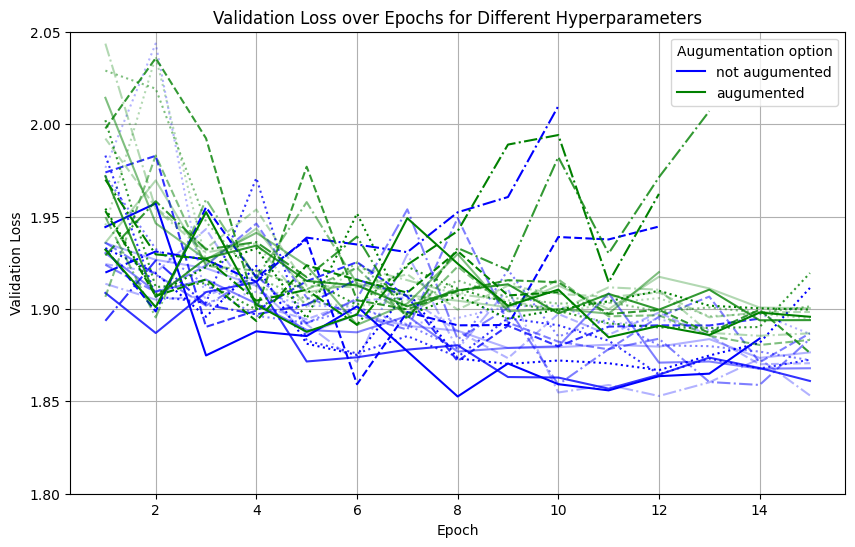

In [28]:
# Define colors and line styles based on learning rate and weight decay
color_map = {'False': 'blue', 'True': 'green'}
line_style_map = {0.001: ':', 0.00075: '-', 0.0005: '--', 0.00025: '-.'}	
opacity_map = {0.0005: 1.0, 0.001: 0.8, 0.0025: 0.5, 0.005: 0.3}

plt.figure(figsize=(10, 6))
for (augument, lr, weight), group_data in grid_df.groupby(['augument', 'learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[augument],
             linestyle=line_style_map[lr],
             alpha=opacity_map[weight])
# Setting the y-axis limits
plt.ylim(1.8, 2.05)
# Create custom legends
last_line = mlines.Line2D([], [], color='blue', linestyle='-', label='not augumented')
last_plus_one_line = mlines.Line2D([], [], color='green', linestyle='-', label='augumented')

plt.legend(handles=[last_line, last_plus_one_line], title="Augumentation option")

plt.title('Validation Loss over Epochs for Different Hyperparameters')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
df_2 = grid_df[grid_df['augument'] == "False"]

# Define colors and line styles based on learning rate and weight decay
color_map = {0.001: 'blue', 0.00075: 'green', 0.0005: 'red', 0.00025: 'purple'}
line_style_map = {0.0005: ':', 0.001: '-', 0.0025: '--', 0.005: '-.'}	
opacity_map = {0.0005: 1.0, 0.001: 0.8, 0.0025: 0.5, 0.005: 0.3}


# Sample data plotting
plt.figure(figsize=(10, 6))
for (lr, weight), group_data in df_2.groupby(['learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[lr],
             linestyle=line_style_map[weight],
             alpha=opacity_map[weight])

# Setting the y-axis limits
plt.ylim(1.85, 2.05)

# Create custom legends
legend_handles = [
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Learning Rates:', linestyle='None'),
    mlines.Line2D([], [], color='blue', label='0.002'),
    mlines.Line2D([], [], color='green', label='0.001'),
    mlines.Line2D([], [], color='red', label='0.0005'),
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Weight Decays:', linestyle='None'),
    mlines.Line2D([], [], color='black', linestyle=':', alpha=1.0, label='WD 0.0005'),
    mlines.Line2D([], [], color='black', linestyle='--', alpha=0.7, label='WD 0.001'),
    mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='WD 0.0025'),
    mlines.Line2D([], [], color='black', linestyle='-.', alpha=0.3, label='WD 0.005')
]

plt.legend(handles=legend_handles, title="Legend", loc="upper right", borderaxespad=0.1)
plt.title('Validation Loss over Epochs for "Last Two" Unfreeze Option')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

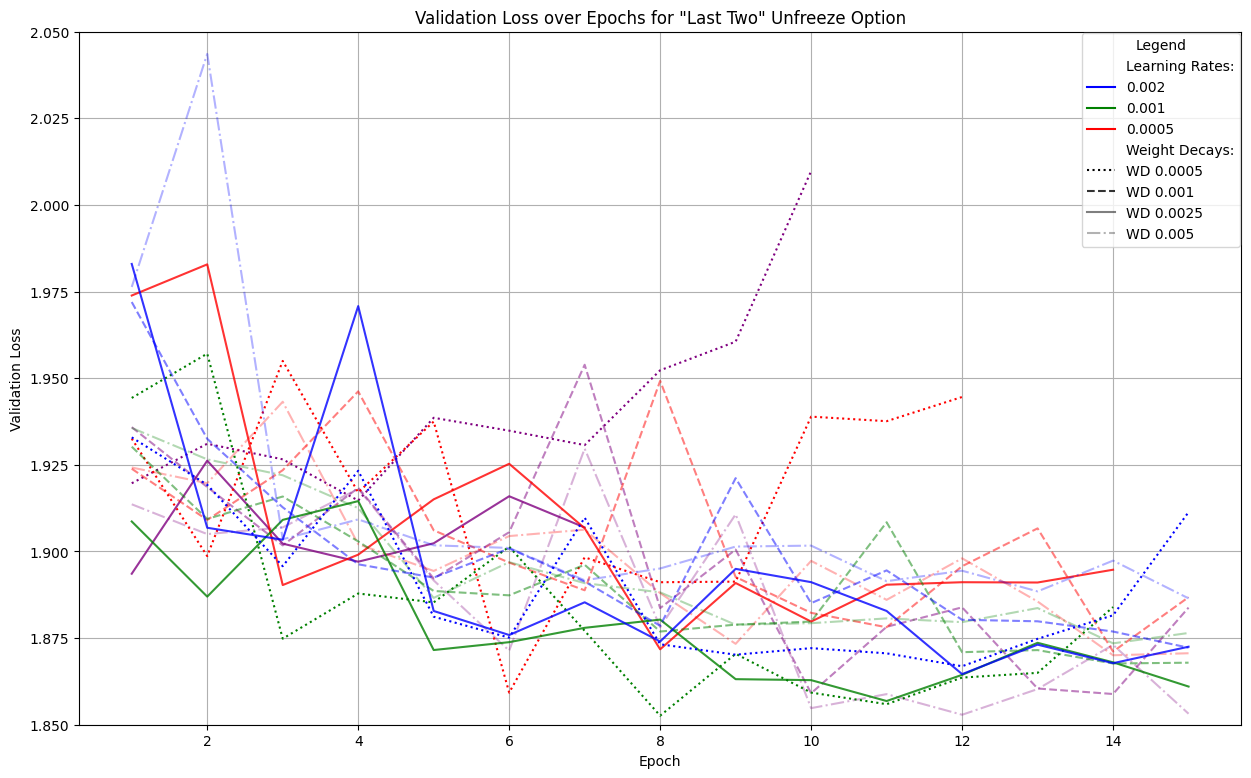

In [39]:
# Define colors and line styles based on learning rate and weight decay
color_map = {0.001: 'blue', 0.00075: 'green', 0.0005: 'red', 0.00025: 'purple'}
line_style_map = {0.0005: ':', 0.001: '-', 0.0025: '--', 0.005: '-.'}	
opacity_map = {0.0005: 1.0, 0.001: 0.8, 0.0025: 0.5, 0.005: 0.3}

# Sample data plotting
plt.figure(figsize=(15, 9))
for (lr, weight), group_data in df_2.groupby(['learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[lr],
             linestyle=line_style_map[weight],
             alpha=opacity_map[weight])

# Setting the y-axis limits
plt.ylim(1.85, 2.05)

# Create custom legends
legend_handles = [
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Learning Rates:', linestyle='None'),
    mlines.Line2D([], [], color='blue', label='0.002'),
    mlines.Line2D([], [], color='green', label='0.001'),
    mlines.Line2D([], [], color='red', label='0.0005'),
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Weight Decays:', linestyle='None'),
    mlines.Line2D([], [], color='black', linestyle=':', alpha=1.0, label='WD 0.0005'),
    mlines.Line2D([], [], color='black', linestyle='--', alpha=0.8, label='WD 0.001'),
    mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='WD 0.0025'),
    mlines.Line2D([], [], color='black', linestyle='-.', alpha=0.3, label='WD 0.005')
]

plt.legend(handles=legend_handles, title="Legend", loc="upper right", borderaxespad=0.1)
plt.title('Validation Loss over Epochs for "Last Two" Unfreeze Option')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()


## Grid search 2 over learning rate, layers and weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a DataFrame to collect all data
all_data = pd.DataFrame()
# Example hyperparameters for the grid search
batch_sizes = [32]  # Add more as needed
learning_rates = [0.002, 0.001, 0.0005]  # Add more as needed
unfreeze_options = ['last_two', 'last_three']  # Options for layers to unfreeze
weight_decays = [0.001, 0.005 ,0.01] 

# Placeholder for best model's performance, now focusing on validation loss
best_loss = float('inf')  # Use infinity as the initial value for the best loss
best_params = {}

# Updated train_and_evaluate function that returns the best validation loss

for batch_size in batch_sizes:
    for lr in learning_rates:
        for unfreeze_option in unfreeze_options:
            for weight_decay in weight_decays:
                print(f"Training with batch size: {batch_size}, learning rate: {lr}, unfreeze option: {unfreeze_option}, weight_decay: {weight_decay}")

                # Load a pretrained ResNet model
                model = models.resnet18(pretrained=True)
                
                # Freeze all parameters first
                for param in model.parameters():
                    param.requires_grad = False

                # Replace the last fully connected layer to adapt to the number of classes (7 in this case)
                num_classes = 7
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)    
                
                # Unfreeze the selected layers based on unfreeze_option
                if unfreeze_option == 'last_two':
                    for param in model.layer4.parameters():
                        param.requires_grad = True
                    for param in model.fc.parameters():
                        param.requires_grad = True
                elif unfreeze_option == 'last_three':
                    # Unfreeze both the last block and the fully connected layer
                    for param in model.layer3.parameters():
                        param.requires_grad = True
                    for param in model.layer4.parameters():
                        param.requires_grad = True
                    for param in model.fc.parameters():
                        param.requires_grad = True
                
                model = model.to(device)
                #print(model)

                # Assuming you've already defined your datasets
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
                criterion = nn.CrossEntropyLoss()
                scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=2, verbose=True)
                 
                 # Prepare config details for data recording
                config_details = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'unfreeze_option': unfreeze_option,
                    'weight_decay': weight_decay
                }

                
                # Run training and evaluation, now expecting validation loss as the return value
                val_loss, data_df = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, patience=6, config_details=config_details)  # Adjust num_epochs and patience as needed

                # Append results to the master DataFrame
                all_data = pd.concat([all_data, data_df], ignore_index=True)
                # Save the complete data to CSV
                all_data.to_csv('/workspace/workspace/ufo-prediction/demo/gridsearch2.csv', index=False)

                # Update best model tracking based on validation loss
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {'batch_size': batch_size, 'learning_rate': lr, 'unfreeze_option': unfreeze_option, 'weight_decay': weight_decay}


# Print the best parameters and validation loss
print(f"Best Parameters: {best_params}, Best Validation Loss: {best_loss}")


Best Parameters: {'batch_size': 32, 'learning_rate': 0.0005, 'unfreeze_option': 'last_two', 'weight_decay': 0.005}, Best Validation Loss: 1.8506267997176766

## Evaluate grid search 2

Result documentation Grid search 2, see gridsearch2.csv

In [ ]:
grid_df = pd.read_csv('/workspace/workspace/ufo-prediction/demo/gridsearch2.csv', encoding='latin1')

In [ ]:
grid_df['epoch'] = grid_df['epoch'].astype(int)
grid_df['batch_size'] = grid_df['batch_size'].astype(int)
grid_df['learning_rate'] = grid_df['learning_rate'].astype(float)
grid_df['validation_loss'] = grid_df['validation_loss'].astype(float)
grid_df['weight_decay'] = grid_df['weight_decay'].astype(float)
grid_df


In [ ]:
import matplotlib.lines as mlines

# Define colors and line styles based on learning rate and weight decay
color_map = {'last_two': 'blue', 'last_three': 'green'}
line_style_map = {0.002: ':', 0.001: '-', 0.0005: '--'}
opacity_map = {0.001: 1.0, 0.005: 0.7, 0.01: 0.4}

plt.figure(figsize=(10, 6))
for (unfreeze_option, lr, weight), group_data in grid_df.groupby(['unfreeze_option', 'learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[unfreeze_option],
             linestyle=line_style_map[lr],
             alpha=opacity_map[weight])
# Setting the y-axis limits
plt.ylim(1.8, 2.05)
# Create custom legends
last_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Last two')
last_plus_one_line = mlines.Line2D([], [], color='green', linestyle='-', label='Last Three')

plt.legend(handles=[last_line, last_plus_one_line], title="Unfreeze Option")

plt.title('Validation Loss over Epochs for Batch Size 32')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define colors and line styles based on learning rate and weight decay
color_map = {0.002: 'blue', 0.001: 'green', 0.0005: 'red'}
line_style_map = {0.001: ':', 0.005: '--', 0.01: '-'}
opacity_map = {0.001: 1.0, 0.005: 0.7, 0.01: 0.5}

# Sample data plotting
plt.figure(figsize=(10, 6))
for (lr, weight), group_data in df_2.groupby(['learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[lr],
             linestyle=line_style_map[weight],
             alpha=opacity_map[weight])

# Setting the y-axis limits
plt.ylim(1.85, 2.05)

# Create custom legends
legend_handles = [
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Learning Rates:', linestyle='None'),
    mlines.Line2D([], [], color='blue', label='0.002'),
    mlines.Line2D([], [], color='green', label='0.001'),
    mlines.Line2D([], [], color='red', label='0.0005'),
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Weight Decays:', linestyle='None'),
    mlines.Line2D([], [], color='black', linestyle=':', alpha=1.0, label='WD 0.001'),
    mlines.Line2D([], [], color='black', linestyle='--', alpha=0.7, label='WD 0.005'),
    mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='WD 0.01')
]

plt.legend(handles=legend_handles, title="Legend", loc="upper right", borderaxespad=0.1)
plt.title('Validation Loss over Epochs for "Last Two" Unfreeze Option')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

df_2_small = df_2[df_2['learning_rate'].isin([0.001, 0.0005])]

# Define colors and line styles based on learning rate and weight decay
color_map = {0.001: 'blue', 0.0005: 'green'}
line_style_map = {0.001: ':', 0.005: '--', 0.01: '-'}
opacity_map = {0.001: 1.0, 0.005: 0.7, 0.01: 0.5}

# Sample data plotting
plt.figure(figsize=(15, 9))
for (lr, weight), group_data in df_2_small.groupby(['learning_rate', 'weight_decay']):
    plt.plot(group_data['epoch'], group_data['validation_loss'], 
             color=color_map[lr],
             linestyle=line_style_map[weight],
             alpha=opacity_map[weight])

# Setting the y-axis limits
plt.ylim(1.85, 2.05)

# Create custom legends
legend_handles = [
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Learning Rates:', linestyle='None'),
    mlines.Line2D([], [], color='blue', label='0.001'),
    mlines.Line2D([], [], color='green', label='0.0005'),
    mlines.Line2D([], [], color='none', marker='s', markersize=10,
                  label='Weight Decays:', linestyle='None'),
    mlines.Line2D([], [], color='black', linestyle=':', alpha=1.0, label='WD 0.001'),
    mlines.Line2D([], [], color='black', linestyle='--', alpha=0.7, label='WD 0.005'),
    mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='WD 0.01')
]

plt.legend(handles=legend_handles, title="Legend", loc="upper right", borderaxespad=0.1)
plt.title('Validation Loss over Epochs for "Last Two" Unfreeze Option')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()


Main takeaways:
- unfreezing three layers is far too much!! consistently worse performance and fluctuates a alot
- Learning rate 0.001 and 0.0005 do better than higher learning rate 0.002. It seems like learning rate 0.005 performs the best
- Weight 0.01 seems to be too strong, but weight 0.005 seems to hit the sweet spot.

Considerations for 3rd grid search:
- 

## Grid search 1 over learning rate, batch sizes and layers (using validation loss)

In [ ]:
#################################
####### DON'T RUN THIS CELL######
####### YOU LOOSE RESULTS #######
#################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example hyperparameters for the grid search
batch_sizes = [16, 32]  # Add more as needed
learning_rates = [0.001, 0.0005]  # Add more as needed
unfreeze_options = ['last', 'last_plus_one']  # Options for layers to unfreeze
weight_decays = [0, 0.001, 0.01] 

# Placeholder for best model's performance, now focusing on validation loss
best_loss = float('inf')  # Use infinity as the initial value for the best loss
best_params = {}

# Updated train_and_evaluate function that returns the best validation loss

for batch_size in batch_sizes:
    for lr in learning_rates:
        for unfreeze_option in unfreeze_options:
            for weight_decay in weight_decays:
                print(f"Training with batch size: {batch_size}, learning rate: {lr}, unfreeze option: {unfreeze_option}, weight_decay: {weight_decay}")

                # Load a pretrained ResNet model
                model = models.resnet18(pretrained=True)
                
                # Freeze all parameters first
                for param in model.parameters():
                    param.requires_grad = False

                # Replace the last fully connected layer to adapt to the number of classes (7 in this case)
                num_classes = 7
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)    
                
                # Unfreeze the selected layers based on unfreeze_option
                if unfreeze_option == 'last':
                    for param in model.fc.parameters():
                        param.requires_grad = True
                elif unfreeze_option == 'last_plus_one':
                    # Unfreeze both the last block and the fully connected layer
                    for param in model.layer4.parameters():
                        param.requires_grad = True
                    for param in model.fc.parameters():
                        param.requires_grad = True
                
                model = model.to(device)
                print(model)

                # Assuming you've already defined your datasets
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
                criterion = nn.CrossEntropyLoss()
                scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
                
                # Run training and evaluation, now expecting validation loss as the return value
                val_loss = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=10, patience=5)  # Adjust num_epochs and patience as needed

                # Update best model tracking based on validation loss
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {'batch_size': batch_size, 'learning_rate': lr, 'unfreeze_option': unfreeze_option, 'weight_decay': weight_decay}

print(f"Best Parameters: {best_params}, Best Validation Loss: {best_loss}")


Winner: Training with batch size: 32, learning rate: 0.001, unfreeze option: last_plus_one, weight_decay: 0.001 
Second place: Training with batch size: 32, learning rate: 0.0005, unfreeze option: last_plus_one, weight_decay: 0.001

## Evaluate Grid search 1

In [ ]:
import matplotlib.pyplot as plt

data = {
    ('16', '0.001', 'last', '0.0'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9685, 1.9444, 1.9926, 1.9655, 2.0739, 1.9833, 1.9420, 1.9320, 1.9304, 1.9358]
    },
    ('16', '0.001', 'last', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9517, 1.9972, 1.9804, 1.9631, 1.9666, 1.9320, 1.9266, 1.9381, 1.9243, 1.9270]
    },
    ('16', '0.001', 'last', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9899, 1.9899, 2.0162, 2.0441, 1.9563, 1.9701, 1.9721, 2.0170, 2.0370, 1.9229]
    },
    ('16', '0.001', 'last_plus_one', '0.0'): {
        'epochs': list(range(1, 7)),
        'val_loss': [1.9197, 1.9766, 1.9536, 1.9577, 1.9242, 1.9299]
    },
    ('16', '0.001', 'last_plus_one', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9153, 1.9053, 1.9385, 1.9027, 1.9083, 1.8985, 1.9088, 1.8998, 1.9107, 1.9215]
    },
    ('16', '0.001', 'last_plus_one', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9469, 1.9239 , 1.9252, 1.9216, 1.9195, 1.9218, 1.9247, 1.9222, 1.9281, 1.9179]
    },
    ('16', '0.0005', 'last', '0.0'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9649, 1.9794, 2.0047, 1.9469, 1.9876, 1.9480, 1.9691, 1.9445, 1.9390, 1.9382]
    },
    ('16', '0.0005', 'last', '0.001'): {
        'epochs': list(range(1, 10)),
        'val_loss': [1.9605, 1.9945, 1.9374, 1.9243, 1.9425, 1.9635, 2.0003, 1.9595, 1.9270]
    },
    ('16', '0.0005', 'last', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9738, 1.9973, 1.9720, 1.9647, 1.9678, 1.9311, 1.9802, 1.9382, 2.0016, 1.9707]
    },
    ('16', '0.0005', 'last_plus_one', '0.0'): {
        'epochs': list(range(1, 9)),
        'val_loss': [1.9217, 1.9560, 1.9156, 1.9302, 2.0055, 1.9553, 1.9418, 1.9995]
    },
    ('16', '0.0005', 'last_plus_one', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9307, 1.9440, 1.9675, 1.9231, 1.8938, 1.9025, 1.9048, 1.9011, 1.9055, 1.8989]
    },
    ('16', '0.0005', 'last_plus_one', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9570, 1.9303, 1.9075, 1.9010, 1.9060, 1.9036, 1.9074, 1.8984, 1.9134, 1.8998]
    },
    ('32', '0.001', 'last', '0.0'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9694, 1.9687, 1.9652, 2.0242, 1.9505, 1.9766, 1.9877, 1.9332, 2.0640, 1.9687]
    },
    ('32', '0.001', 'last', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9621, 1.9582, 1.9517, 1.9498, 1.9521, 1.9865, 2.0043, 1.9914, 1.9216, 1.9287]
    },
    ('32', '0.001', 'last', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9777, 2.0244, 1.9356, 1.9492, 1.9750, 1.9384, 1.9582, 1.9274, 1.9239, 1.9195]
    },
    ('32', '0.001', 'last_plus_one', '0.0'): {
        'epochs': list(range(1, 7)),
        'val_loss': [1.9203, 1.9230, 1.9382, 1.9693, 1.9642, 1.9443]
    },
    ('32', '0.001', 'last_plus_one', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9564, 1.9444, 1.9294, 1.9042, 1.8981, 1.8919, 1.8903, 1.9232, 1.9147, 1.9047]
    },
    ('32', '0.001', 'last_plus_one', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9651, 1.9272, 1.9288, 1.9062, 1.9077, 1.9048, 1.9070, 1.9070, 1.9131, 1.9061]
    },
    ('32', '0.0005', 'last', '0.0'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9510, 1.9450, 1.9307, 1.9272, 1.9340, 1.9228, 1.9563, 1.9333, 1.9299, 1.9298]
    },
    ('32', '0.0005', 'last', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9507, 1.9739, 1.9368, 1.9388, 1.9310, 1.9217, 1.9329, 1.9515, 1.9228, 1.9368]
    },
    ('32', '0.0005', 'last', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9423, 1.9543, 1.9290, 1.9591, 1.9186, 1.9304, 1.9246, 1.9260, 1.9213, 1.9210]
    },
    ('32', '0.0005', 'last_plus_one', '0.0'): {
        'epochs': list(range(1, 7)),
        'val_loss': [1.9113, 1.9215, 1.9495, 1.9411, 1.9571, 1.9851]
    },
    ('32', '0.0005', 'last_plus_one', '0.001'): {
        'epochs': list(range(1, 11)),
        'val_loss': [1.9109, 1.9330, 1.9209, 1.9342, 1.9109, 1.9056, 1.9072, 1.8923, 1.8976, 1.9530]
    },
    ('32', '0.0005', 'last_plus_one', '0.01'): {
        'epochs': list(range(1, 11)),
        'val_loss': [2.0175, 1.9383, 1.9402, 1.8973, 1.9037, 1.8941, 1.9014, 1.8981, 1.9023, 1.9071]
    },
}




In [ ]:
# Create a DataFrame to make plotting easier
df_list = []
for key, values in data.items():
    batch_size, lr, unfreeze_option, weight_decay = key
    for epoch, val_loss in zip(values['epochs'], values['val_loss']):
        df_list.append({
            'Batch Size': batch_size,
            'Learning Rate': lr,
            'Unfreeze Option': unfreeze_option,
            'Weight Decay': weight_decay,
            'Epoch': epoch,
            'Validation Loss': val_loss
        })

df = pd.DataFrame(df_list)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

# Filter data for different unfreeze options and plot
for unfreeze_option in df['Unfreeze Option'].unique():
    subset = df[df['Unfreeze Option'] == unfreeze_option]
    for batch_size in subset['Batch Size'].unique():
        filtered_data = subset[subset['Batch Size'] == batch_size]
        axs[0].plot(filtered_data['Epoch'], filtered_data['Validation Loss'], marker='o', label=f'{unfreeze_option} bs={batch_size}')
    axs[0].set_title('Validation Loss over Epochs by Unfreeze Option and Batch Size')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Validation Loss')
    axs[0].legend()

# Filter data for different weight decays and plot
for weight_decay in df['Weight Decay'].unique():
    subset = df[df['Weight Decay'] == weight_decay]
    for batch_size in subset['Batch Size'].unique():
        filtered_data = subset[subset['Batch Size'] == batch_size]
        axs[1].plot(filtered_data['Epoch'], filtered_data['Validation Loss'], marker='o', label=f'wd={weight_decay} bs={batch_size}')
    axs[1].set_title('Validation Loss over Epochs by Weight Decay and Batch Size')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Loss')
    axs[1].legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

# Assuming 'df' is your DataFrame
# Convert 'Batch Size' to integer
df['Batch Size'] = df['Batch Size'].astype(int)

# Filtering for batch size 32
df_32 = df[df['Batch Size'] == 32]

# Define colors and line styles based on learning rate and weight decay
color_map = {'last': 'blue', 'last_plus_one': 'green'}
line_style_map = {'0.001': '-', '0.0005': '--'}
opacity_map = {'0.0': 1.0, '0.001': 0.7, '0.01': 0.4}

plt.figure(figsize=(10, 6))
for (unfreeze_option, lr, weight), group_data in df_32.groupby(['Unfreeze Option', 'Learning Rate', 'Weight Decay']):
    plt.plot(group_data['Epoch'], group_data['Validation Loss'], 
             color=color_map[unfreeze_option],
             linestyle=line_style_map[lr],
             alpha=opacity_map[weight])

# Create custom legends
last_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Last')
last_plus_one_line = mlines.Line2D([], [], color='green', linestyle='-', label='Last + One')

plt.legend(handles=[last_line, last_plus_one_line], title="Unfreeze Option")

plt.title('Validation Loss over Epochs for Batch Size 32')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

# Convert 'Batch Size' to integer if not already done
df['Batch Size'] = df['Batch Size'].astype(int)

# Filtering data based on your specified criteria
filtered_df = df[(df['Weight Decay'].isin(['0.001', '0.01'])) & (df['Unfreeze Option'] == 'last_plus_one')]

# Define colors by batch size, line styles by learning rate, and opacity by weight decay
color_map = {16: 'red', 32: 'blue'}
line_style_map = {'0.001': '-', '0.0005': '--'}
opacity_map = {'0.001': 0.7, '0.01': 0.4}

plt.figure(figsize=(10, 6))
for (batch_size, lr, weight), group_data in filtered_df.groupby(['Batch Size', 'Learning Rate', 'Weight Decay']):
    plt.plot(group_data['Epoch'], group_data['Validation Loss'], 
             color=color_map[batch_size],
             linestyle=line_style_map[lr],
             alpha=opacity_map[weight],
             label=f'Batch {batch_size}, LR {lr}, Weight {weight}')

# Create custom legend for batch sizes
batch_16_line = mlines.Line2D([], [], color='red', linestyle='-', label='Batch Size 16')
batch_32_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Batch Size 32')

plt.legend(handles=[batch_16_line, batch_32_line], title="Batch Size")

plt.title('Validation Loss over Epochs for two unfrozen layers')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
line_styles = {'0.0': '-', '0.001': '--', '0.01': '-.'}
colors = {'0.001': 'blue', '0.0005': 'red'}

for (lr, weight_decay), group in df[(df['Unfreeze Option'] == 'last_plus_one') & (df['Batch Size'] == '32')].groupby(['Learning Rate', 'Weight Decay']):
    plt.plot(group['Epoch'], group['Validation Loss'], linestyle=line_styles[weight_decay], color=colors[lr],
             label=f'LR: {lr}, Weight Decay: {weight_decay}')

plt.title('Validation Loss over Epochs for Batch Size 32 with Last Plus One Unfrozen')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title="Parameters")
plt.grid(True)
plt.show()

Main takeaways:
- two unfrozen layers are better than one.
- batch size does not make a big difference, but 32 is a bit better.
- A weight decay of 0 is worse than 0.001 or 0.01. Between 0.001 and 0.01, it seems to depend on the learning rate. i.e. lr0.0005 with wd0.01 and lr0.001 with wd0.0001 perform best
- Weight decay 0.001 leads to validation loss picking up again after 8-10 epochs, while this is not true for weight loss 0.01

## Result documentation Grid search 1 (final) - see WORD Document